# Searching a pairwise distance matrix for specific points:

In this notebook you can compare the performance of a classic combinatorics method to find the indices of two points in an array with a precise distance to scipy's squareform method and a [triangular numbers approach](https://mathworld.wolfram.com/TriangularNumber.html).

The first half of this notebook steps through an example of how the triangular numbers approach works. In the second half, you can compare the time required for each method, which clearly displays the decrease in computational time 
of using triangular numbers.

## Roberts playground

In this modified notebook we compare the method with a _brute force_ parallel approach using GPU-accelerated processing, [OpenCL](https://www.khronos.org/opencl/#:~:text=OpenCL%E2%84%A2%20(Open%20Computing%20Language,mobile%20devices%20and%20embedded%20platforms.) and the [clesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) library.

In [1]:
# import required functionalities

from __future__ import division, print_function

import time
import numpy as np
import matplotlib.pyplot as plt

from os import getcwd
from os.path import join
from itertools import combinations
from scipy.spatial.distance import pdist, squareform

%matplotlib inline

from functools import partial
from timeit import timeit
import stackview
import pyclesperanto_prototype as cle
from scipy import ndimage as ndi

In [2]:
# define triangular numbers-based search function

def index_pair_from_condensed_form(array, condensed_idx):
    
    '''this function uses triangular numbers formulas to convert a condensed form distance matrix index
       (condensed_idx) into a pair of indices for returning points from the original pointset (array).
       
       
       Let T(x) be the x'th triangular number (i.e., the sum of the numbers from 1 to x). 
       The formula for T(x) is simple:
       T(x) = (x * (x + 1)) / 2
       
       
       Given y = T(x) we can calculate x by inverting the above formula:
       x = (((8y + 1) ** 0.5) - 1) / 2'''
    
    i = condensed_idx
    n = array.shape[0] - 1
    t_n = (n * (n+1)) / 2
    y = t_n - i - 1
    d = 1 + int((((8 * y + 1) ** 0.5) - 1) / 2)
    k = n - d
    k_star = 1 + i + k + ((d * (d + 1)) / 2) - t_n
    
    return int(k), int(k_star)

### Create a matrix with shape (n_pts, 3) to store n points of interest with dimension m (e.g., a pointcloud)

In [3]:
n_pts = 10
m_dim = 3
largest_val = 500

arr = np.random.randint(0, largest_val, (n_pts, m_dim))

### Compute the pairwise distance matrix of the point set

In [4]:
d = pdist(arr)
d

array([429.99651161, 195.51726266, 373.65625915, 387.25443832,
       104.6231332 , 413.96859784, 546.65894303, 487.95184189,
       399.51220257, 348.69184103, 201.63829001, 467.3810009 ,
       500.02899916, 357.2268187 , 368.63125207, 225.30867715,
       437.91665874, 239.9749987 , 210.18325338, 294.41637183,
       222.71281957, 369.79318544, 342.70395387, 241.14103757,
       302.92078172, 470.11594315, 194.62014284, 217.24410234,
       114.81289126, 242.2581268 , 483.96280849, 139.23361663,
       287.98263837, 356.52349151, 138.22445514, 515.68013342,
       649.51828304, 583.92893403, 502.70269544, 167.34993278,
       224.43484578, 144.23591786, 157.81318069, 229.20296682,
       289.92930173])

## The distance matrix in square form looks like this

StackViewNDArray([[  0.        , 429.99651161, 195.51726266,
                   373.65625915, 387.25443832, 104.6231332 ,
                   413.96859784, 546.65894303, 487.95184189,
                   399.51220257],
                  [429.99651161,   0.        , 348.69184103,
                   201.63829001, 467.3810009 , 500.02899916,
                   357.2268187 , 368.63125207, 225.30867715,
                   437.91665874],
                  [195.51726266, 348.69184103,   0.        ,
                   239.9749987 , 210.18325338, 294.41637183,
                   222.71281957, 369.79318544, 342.70395387,
                   241.14103757],
                  [373.65625915, 201.63829001, 239.9749987 ,
                     0.        , 302.92078172, 470.11594315,
                   194.62014284, 217.24410234, 114.81289126,
                   242.2581268 ],
                  [387.25443832, 467.3810009 , 210.18325338,
                   302.92078172,   0.        , 483.96280849,
                   139.23361663, 287.98263837, 356.52349151,
                   138.22445514],
                  [104.6231332 , 500.02899916, 294.41637183,
                   470.11594315, 483.96280849,   0.        ,
                   515.68013342, 649.51828304, 583.92893403,
                   502.70269544],
                  [413.96859784, 357.2268187 , 222.71281957,
                   194.62014284, 139.23361663, 515.68013342,
                     0.        , 167.34993278, 224.43484578,
                   144.23591786],
                  [546.65894303, 368.63125207, 369.79318544,
                   217.24410234, 287.98263837, 649.51828304,
                   167.34993278,   0.        , 157.81318069,
                   229.20296682],
                  [487.95184189, 225.30867715, 342.70395387,
                   114.81289126, 356.52349151, 583.92893403,
                   224.43484578, 157.81318069,   0.        ,
                   289.92930173],
                  [399.51220257, 437.91665874, 241.14103757,
                   242.2581268 , 138.22445514, 502.70269544,
                   144.23591786, 229.20296682, 289.92930173,
                     0.        ]])
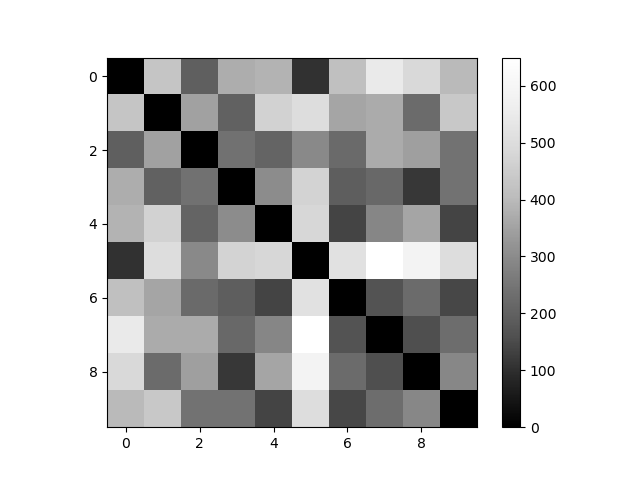
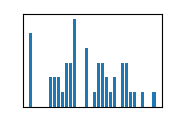

In [5]:
m = squareform(d)
stackview.insight(m)

## Before we can determine the minimum in this matrix, we should overwrite the diagonale with large values. Therefore it is handy to know the maximum value.

StackViewNDArray([[501.        , 429.99651161, 195.51726266,
                   373.65625915, 387.25443832, 104.6231332 ,
                   413.96859784, 546.65894303, 487.95184189,
                   399.51220257],
                  [429.99651161, 501.        , 348.69184103,
                   201.63829001, 467.3810009 , 500.02899916,
                   357.2268187 , 368.63125207, 225.30867715,
                   437.91665874],
                  [195.51726266, 348.69184103, 501.        ,
                   239.9749987 , 210.18325338, 294.41637183,
                   222.71281957, 369.79318544, 342.70395387,
                   241.14103757],
                  [373.65625915, 201.63829001, 239.9749987 ,
                   501.        , 302.92078172, 470.11594315,
                   194.62014284, 217.24410234, 114.81289126,
                   242.2581268 ],
                  [387.25443832, 467.3810009 , 210.18325338,
                   302.92078172, 501.        , 483.96280849,
                   139.23361663, 287.98263837, 356.52349151,
                   138.22445514],
                  [104.6231332 , 500.02899916, 294.41637183,
                   470.11594315, 483.96280849, 501.        ,
                   515.68013342, 649.51828304, 583.92893403,
                   502.70269544],
                  [413.96859784, 357.2268187 , 222.71281957,
                   194.62014284, 139.23361663, 515.68013342,
                   501.        , 167.34993278, 224.43484578,
                   144.23591786],
                  [546.65894303, 368.63125207, 369.79318544,
                   217.24410234, 287.98263837, 649.51828304,
                   167.34993278, 501.        , 157.81318069,
                   229.20296682],
                  [487.95184189, 225.30867715, 342.70395387,
                   114.81289126, 356.52349151, 583.92893403,
                   224.43484578, 157.81318069, 501.        ,
                   289.92930173],
                  [399.51220257, 437.91665874, 241.14103757,
                   242.2581268 , 138.22445514, 502.70269544,
                   144.23591786, 229.20296682, 289.92930173,
                   501.        ]])
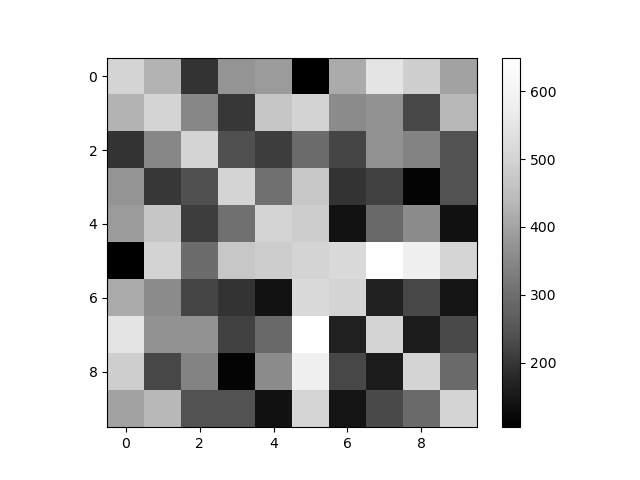
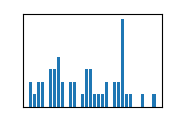

In [6]:
np.fill_diagonal(m, largest_val + 1)
stackview.insight(m)

In [7]:
ndi.minimum_position(m)

(0, 5)

## Formulate the entire thing as function for later benchmarking


In [8]:
def find_minimum_distance_ndi(coords):
    '''
    Finds the point-pair indices with minimal distance in a list of n-dimensional coordinates.
    '''
    d = pdist(arr)
    
    m = squareform(d)

    np.fill_diagonal(m, largest_val + 1)

    return ndi.minimum_position(m)

In [9]:
find_minimum_distance_ndi(arr)

(0, 5)

### Find array index of desired mathematical argument (e.g., minimal distance)

In [10]:
idx = np.argmin(d)
idx

4

### Assign result of mathematical argument to a variable

In [11]:
value = d[idx]
print(value == np.amin(d))

True


### Convert index to pair of indices in original point set

In [12]:
idx_1, idx_2 = index_pair_from_condensed_form(arr, idx)
idx_1, idx_2

(0, 5)

## Formulate the entire thing as function for later benchmarking

In [13]:
def find_minimum_distance_tri(coords):
    '''
    Finds the point-pair indices with minimal distance in a list of n-dimensional coordinates.
    '''
    d = pdist(coords)
    
    idx = np.argmin(d)
    d = pdist(arr)
    idx_1, idx_2 = index_pair_from_condensed_form(arr, idx)

    return (idx_1, idx_2)

In [14]:
find_minimum_distance_tri(arr)

(0, 5)

# GPU 'deceleration'

[`clesperanto`](https://github.com/clEsperanto/pyclesperanto_prototype) expects the points in a different shape. That's why we transpose `.T` it here.

In [15]:
coords = cle.asarray(arr.T)

## Compute distance matrix
In clesperanto distance/adjacency matrices contain a column/row for background. 
To crop it off, we use [1:, 1:]. Then, the matrix is identical with `squareform` above.

cl.OCLArray([[  0.     , 429.9965 , 195.51726, 373.65625, 387.25443, 104.62313,
        413.9686 , 546.65894, 487.95184, 399.5122 ],
       [429.9965 ,   0.     , 348.69183, 201.63829, 467.381  , 500.029  ,
        357.2268 , 368.63126, 225.30867, 437.91666],
       [195.51726, 348.69183,   0.     , 239.97499, 210.18326, 294.41638,
        222.71281, 369.79318, 342.70395, 241.14104],
       [373.65625, 201.63829, 239.97499,   0.     , 302.92078, 470.11594,
        194.62015, 217.2441 , 114.81289, 242.25813],
       [387.25443, 467.381  , 210.18326, 302.92078,   0.     , 483.9628 ,
        139.23361, 287.98264, 356.5235 , 138.22446],
       [104.62313, 500.029  , 294.41638, 470.11594, 483.9628 ,   0.     ,
        515.6801 , 649.51825, 583.9289 , 502.7027 ],
       [413.9686 , 357.2268 , 222.71281, 194.62015, 139.23361, 515.6801 ,
          0.     , 167.34993, 224.43484, 144.23592],
       [546.65894, 368.63126, 369.79318, 217.2441 , 287.98264, 649.51825,
        167.34993,   0.     , 157.81317, 229.20297],
       [487.95184, 225.30867, 342.70395, 114.81289, 356.5235 , 583.9289 ,
        224.43484, 157.81317,   0.     , 289.9293 ],
       [399.5122 , 437.91666, 241.14104, 242.25813, 138.22446, 502.7027 ,
        144.23592, 229.20297, 289.9293 ,   0.     ]], dtype=float32)
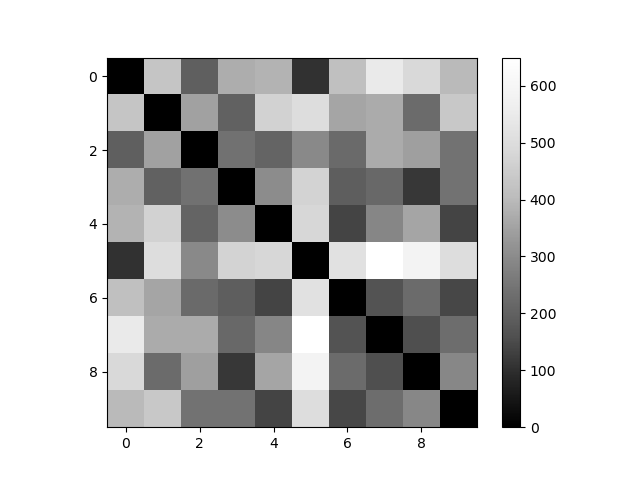
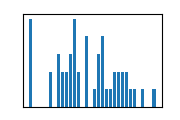

In [16]:
distance_matrix = cle.generate_distance_matrix(coords, coords)[1:,1:]
distance_matrix

In [17]:
# workaround: before determining the minimum position, we should set the diagonale to a high value
# that's a bit wasteful performance-wise but serves the needs
# Note: this will only work if `largest_val` is known. We have to determine it otherwise.
cle.set_where_x_equals_y(distance_matrix, largest_val + 1)

cle.maximum_position(-distance_matrix)

(0, 5)

In [18]:
def find_minimum_distance_cle(coords):
    '''
    Finds the point-pair indices with minimal distance in a list of n-dimensional coordinates.
    '''
    coords = cle.asarray(coords.T)
    m = cle.generate_distance_matrix(coords, coords)[1:,1:]
    cle.set_where_x_equals_y(m, largest_val + 1)

    position = cle.maximum_position(-m)
    
    return position

## Benchmarking
Here we compare now performance of the two different approaches ([read more about benchmarking](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/03_advanced_python/parallelization.html#benchmarking-execution-time)).
As Robert has two GPUs in his laptop, we test both.

In [ ]:
# for timeit/partial see also: 
sizes = [10, 100, 1000, 1500, 2000]
times_ndi = []
times_tri = []
times_cle1 = []
times_cle2 = []

for n_pts in sizes:
    print("\nSize", n_pts)
    arr = np.random.randint(0, largest_val, (n_pts, m_dim))

    res = timeit(partial(find_minimum_distance_ndi, arr), number=5)
    times_ndi.append(res)
    print("ndi", res)
    
    res = timeit(partial(find_minimum_distance_tri, arr), number=5)
    times_tri.append(res)
    print("con", res)

    cle.select_device("TX") # use NVidia GPU
    res = timeit(partial(find_minimum_distance_cle, arr), number=5)
    times_cle1.append(res)
    print("cle1", res)
    
    cle.select_device("fx") # use AMD GPU
    res = timeit(partial(find_minimum_distance_cle, arr), number=5)
    times_cle2.append(res)
    print("cle2", res)



Size 10
ndi 0.0005030000000001422
con 0.00010139999999925209
cle1 0.036936800000000325
cle2 0.03210080000000026

Size 100
ndi 0.0004827000000000581
con 0.00024560000000040105
cle1 0.032784399999999714
cle2 0.0343852999999994

Size 1000
ndi 0.03773309999999963
con 0.018669800000000514
cle1 0.6305756999999996
cle2 0.5594400999999998

Size 1500
ndi 0.10663540000000005
con 0.04866779999999871
cle1 2.1156778999999997
cle2 2.352488599999999

Size 2000
ndi 0.1841337000000003
con 0.08655389999999841
cle1 4.759229199999998


In [ ]:
plt.plot(sizes, times_ndi, label = 'ndi')
plt.plot(sizes, times_tri, label = 'tri')
plt.plot(sizes, times_cle1, label = 'cle')
plt.plot(sizes, times_cle2, label = 'cle')

plt.xlabel('N points pairwise compared')
plt.ylabel('time (seconds)')
plt.legend(['ndi', 'tri', 'cle1', 'cle2'])
plt.show()